## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization
from keras.layers import Dropout
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp1(input_shape, output_units=10, num_neurons=[512, 256, 128],
              regulizer='l1',l1_ratio=1e-4,l2_ratio=1e-4,l1_l2_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    kernel_regularizers = {'l1':l1(l1_ratio),'l2':l2(l2_ratio),'l1_l2':l1_l2(l1_l2_ratio)}
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=kernel_regularizers[regulizer])(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=kernel_regularizers[regulizer])(x)
            
            x = Dropout(drp_ratio)(x)         
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128],
              regulizer='l1',l1_ratio=1e-4,l2_ratio=1e-4,l1_l2_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    kernel_regularizers = {'l1':l1(l1_ratio),'l2':l2(l2_ratio),'l1_l2':l1_l2(l1_l2_ratio)}
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=kernel_regularizers[regulizer])(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=kernel_regularizers[regulizer])(x)
            
            x = Dropout(drp_ratio)(x)         
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

Experiment with Regulizer = 0.010000
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 4s 71us/step - loss: 198.6125 - accuracy: 0.3004 - val_loss: 41.3346 - val_accuracy: 0.1424
Epoch 2/30
50000/50000 [==============================] - 3s 59us/step - loss: 19.2049 - accuracy: 0.2528 - val_loss: 7.4685 - val_accuracy: 0.1003
Epoch 3/30
50000/50000 [==============================] - 3s 59us/step - loss: 4.2032 - accuracy: 0.1274 - val_loss: 2.6969 - val_accuracy: 0.1000
Epoch 4/30
50000/50000 [==============================] - 3s 62us/step - loss: 2.5022 - accuracy: 0.0995 - val_loss: 2.4629 - val_accuracy: 0.1000
Epoch 5/30
50000/50000 [==============================] - 3s 63us/step - loss: 2.4628 - accuracy: 0.0992 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 6/30
50000/50000 [==============================] - 3s 61us/step - loss: 2.4629 - accuracy: 0.0983 - val_loss: 2.4628 - val_accuracy: 0.1000
Epoch 7/30
50000/50000 [===

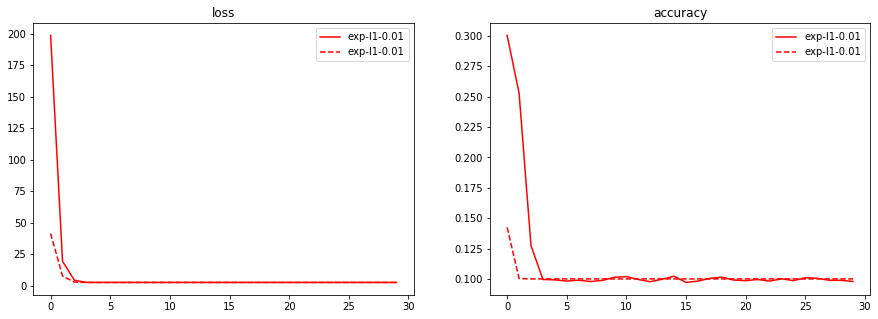

In [8]:
'''
    使用 batch normalization 、dropout、 l1 正規化
'''
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
regulizer_ratio = L1_EXP[0]
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with Regulizer = %.6f" % (regulizer_ratio))

model = build_mlp1(input_shape=x_train.shape[1:],regulizer='l1',l1_ratio=regulizer_ratio)
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.fit(x_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_data=(x_test, y_test), 
        shuffle=True,verbose=1)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}
"""Code Here
將結果繪出
"""

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("loss")
#plt.ylim([0, 5])
plt.legend()
#plt.show()

#plt.figure(figsize=(8,6))
plt.subplot(1,2,2)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("accuracy")
#plt.ylim([0, 5])
plt.legend()
plt.show()


Experiment with Regulizer = 0.010000
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 3s 66us/step - loss: 198.8634 - accuracy: 0.1963 - val_loss: 41.0995 - val_accuracy: 0.2177
Epoch 2/30
50000/50000 [==============================] - 3s 60us/step - loss: 19.0986 - accuracy: 0.1126 - val_loss: 7.2616 - val_accuracy: 0.1000
Epoch 3/30
50000/50000 [==============================] - 3s 64us/step - loss: 4.0965 - accuracy: 0.0978 - val_loss: 2.6420 - val_accuracy: 0.1000
Epoch 4/30
50000/50000 [==============================] - 3s 62us/step - loss: 2.4850 - accuracy: 0.1002 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 5/30
50000/50000 [==============================] - 3s 58us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 6/30
50000/50000 [==============================] - 3s 60us/step - loss: 2.4626 - accuracy: 0.0988 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 7/30
50000/50000 [===

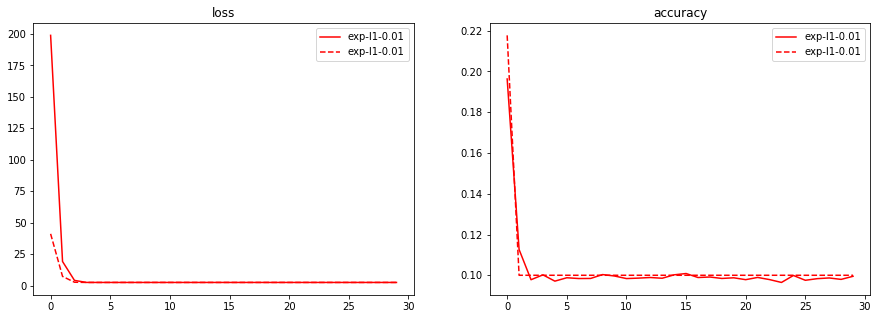

In [9]:
'''
    使用 dropout、 l1 正規化
'''
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
regulizer_ratio = L1_EXP[0]
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with Regulizer = %.6f" % (regulizer_ratio))

model = build_mlp2(input_shape=x_train.shape[1:],regulizer='l1',l1_ratio=regulizer_ratio)
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.fit(x_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_data=(x_test, y_test), 
        shuffle=True,verbose=1)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}
"""Code Here
將結果繪出
"""

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("loss")
#plt.ylim([0, 5])
plt.legend()
#plt.show()

#plt.figure(figsize=(8,6))
plt.subplot(1,2,2)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("accuracy")
#plt.ylim([0, 5])
plt.legend()
plt.show()

Experiment with Regulizer = 0.010000
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 4s 73us/step - loss: 18.7154 - accuracy: 0.3017 - val_loss: 17.2745 - val_accuracy: 0.3734
Epoch 2/30
50000/50000 [==============================] - 3s 63us/step - loss: 15.9857 - accuracy: 0.3924 - val_loss: 14.7971 - val_accuracy: 0.4234
Epoch 3/30
50000/50000 [==============================] - 3s 69us/step - loss: 13.7647 - accuracy: 0.4202 - val_loss: 12.7572 - val_accuracy: 0.4319
Epoch 4/30
50000/50000 [==============================] - 3s 63us/step - loss: 11.8838 - accuracy: 0.4469 - val_loss: 11.0388 - val_accuracy: 0.4544
Epoch 5/30
50000/50000 [==============================] - 3s 62us/step - loss: 10.3009 - accuracy: 0.4599 - val_loss: 9.5810 - val_accuracy: 0.4684
Epoch 6/30
50000/50000 [==============================] - 3s 65us/step - loss: 8.9447 - accuracy: 0.4728 - val_loss: 8.3413 - val_accuracy: 0.4736
Epoch 7/30
50000/50000

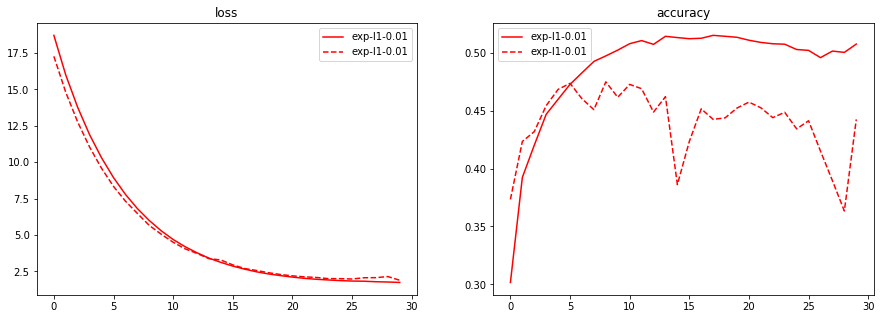

In [10]:
'''
    使用 batch normalization 、dropout、 l1 l2 正規化
'''
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
regulizer_ratio = L1_EXP[0]
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with Regulizer = %.6f" % (regulizer_ratio))

model = build_mlp1(input_shape=x_train.shape[1:],regulizer='l1_l2',l1_ratio=regulizer_ratio)
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.fit(x_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_data=(x_test, y_test), 
        shuffle=True,verbose=1)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}
"""Code Here
將結果繪出
"""

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("loss")
#plt.ylim([0, 5])
plt.legend()
#plt.show()

#plt.figure(figsize=(8,6))
plt.subplot(1,2,2)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("accuracy")
#plt.ylim([0, 5])
plt.legend()
plt.show()

Experiment with Regulizer = 0.010000
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 3s 67us/step - loss: 18.8941 - accuracy: 0.2223 - val_loss: 17.4127 - val_accuracy: 0.3183
Epoch 2/30
50000/50000 [==============================] - 3s 62us/step - loss: 16.2313 - accuracy: 0.3072 - val_loss: 15.0184 - val_accuracy: 0.3502
Epoch 3/30
50000/50000 [==============================] - 3s 62us/step - loss: 14.0366 - accuracy: 0.3342 - val_loss: 13.0087 - val_accuracy: 0.3655
Epoch 4/30
50000/50000 [==============================] - 3s 62us/step - loss: 12.1822 - accuracy: 0.3499 - val_loss: 11.3050 - val_accuracy: 0.3754
Epoch 5/30
50000/50000 [==============================] - 3s 60us/step - loss: 10.6052 - accuracy: 0.3594 - val_loss: 9.8504 - val_accuracy: 0.3862
Epoch 6/30
50000/50000 [==============================] - 3s 60us/step - loss: 9.2632 - accuracy: 0.3690 - val_loss: 8.6185 - val_accuracy: 0.3923
Epoch 7/30
50000/50000

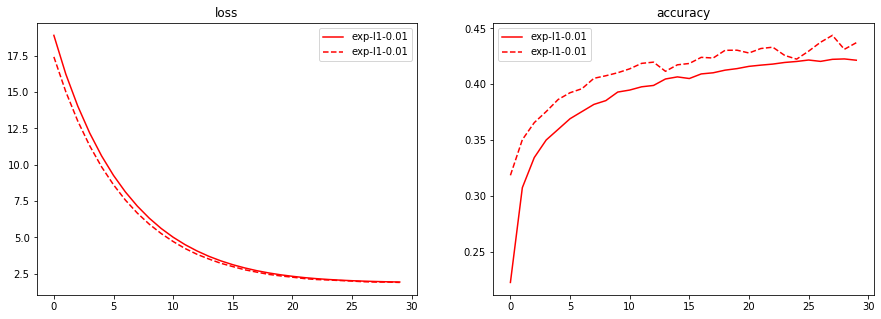

In [11]:
'''
    使用 dropout、 l1 l2 正規化
'''
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
regulizer_ratio = L1_EXP[0]
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with Regulizer = %.6f" % (regulizer_ratio))

model = build_mlp2(input_shape=x_train.shape[1:],regulizer='l1_l2',l1_ratio=regulizer_ratio)
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.fit(x_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_data=(x_test, y_test), 
        shuffle=True,verbose=1)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}
"""Code Here
將結果繪出
"""

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("loss")
#plt.ylim([0, 5])
plt.legend()
#plt.show()

#plt.figure(figsize=(8,6))
plt.subplot(1,2,2)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("accuracy")
#plt.ylim([0, 5])
plt.legend()
plt.show()